In [9]:
!pip3 install boto3

In [10]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Done transferring all datasets


In [11]:
from pycocotools.coco import COCO
import numpy as np
from numpy import asarray
import skimage.io as io
import random
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import cv2
from PIL import Image

In [15]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  img = asarray(img)/255.0
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img)
  pred = model([img.float()])
  # print(pred)
  # pred_class = ['Person' for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  # pred_class = pred_class[:pred_t+1]
  return pred_boxes

In [29]:
def object_detection(img_path, bbox, threshold=0.5, rect_th=3, text_size=1.0, text_th=2):
  boxes = get_prediction(img_path, threshold)
  # Get predictions
  img = cv2.imread(img_path)
  # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # #crop
  # cropped_img = img[int(bbox[1]):int(bbox[1])+int(bbox[3]), int(bbox[0]):int(bbox[0])+int(bbox[2])]
  # #resize
  # resized_img = cv2.resize(cropped_img,(256,192))
  # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    # Draw Rectangle with the coordinates
    cv2.putText(img,'Person', boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    # PIL_image = Image.fromarray(img)
    # resized_img = PIL_image.resize((256,192), box=(int(bbox[0]),int(bbox[1]),int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])))
    # np_resized_img = np.array(resized_img)
  plt.figure(figsize=(10,8))
  # display the output image
  plt.imshow(img) 
  plt.xticks([]) 
  plt.yticks([]) 
  plt.show()

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!


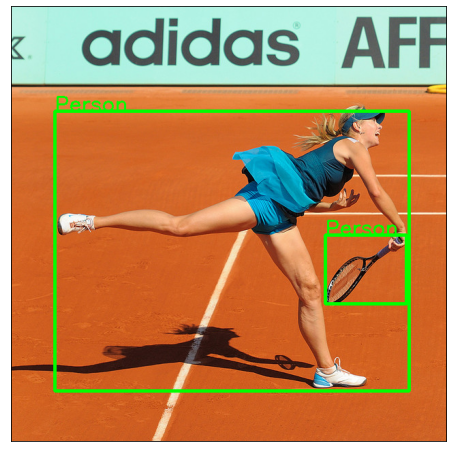

In [30]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) 
model.eval()

dataDir = '/content'
dataType = 'val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)
catID = coco.getCatIds(catNms='person')
imgIds = coco.getImgIds(catIds=catID)
# load and display random images
images = random.sample(imgIds,1)

for img_id in coco.loadImgs(images):
  file_name = img_id['file_name']
  img_path = dataDir + '/' + dataType + '/' + file_name
  gt_ann_ids = coco.getAnnIds(imgIds=[img_id["id"]])
  gt_anns = coco.loadAnns(gt_ann_ids)
  for gt in gt_anns:
    bbox = gt['bbox']

  object_detection(img_path, bbox, threshold=0.9)

  # plt.axis('off')
  # plt.imshow(img)
  # plt.show()